# Bayesian Dynamic TWFE

In [2]:
import re
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

import scipy.stats as stats
from patsy import dmatrix
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')

In [189]:
filepath = '../../data/processed/df_filtered.xlsx'
df = pd.read_excel(filepath)
df = df.dropna(subset=['population'])
df.loc[df['treatment_group'] == 0, 'time_since_treatment'] = np.nan # コントロール群の処置後経過年数は欠損値
df['time_since_treatment'] = np.nan_to_num(df['time_since_treatment'], nan=1000)


In [252]:
df.island_ids = df.island_ids.astype(str)
df.island_ids = df.island_ids.map(str.strip)
island_id, mn_island_ids = df.island_ids.factorize()

df.bridge_year = df.bridge_year.astype(str)
df.bridge_year = df.bridge_year.map(str.strip)
bridge_years, mn_bridge_years = df.bridge_year.factorize()

df['time_since_treatment'] = df['time_since_treatment'].astype(str)
df['time_since_treatment'] = df['time_since_treatment'].map(str.strip)
time_since_treatment, mn_time_since_treatments = df['time_since_treatment'].factorize()


## Dynamic TWFE

$$
\begin{aligned}
Y_{it} = \alpha_i + \lambda_t + \beta_l \cdot T_{i}  + \epsilon_{it} \\
\end{aligned}
$$

- $\beta_l$: 介入前後の経過時間

## 階層ベイズモデル 不均一分散

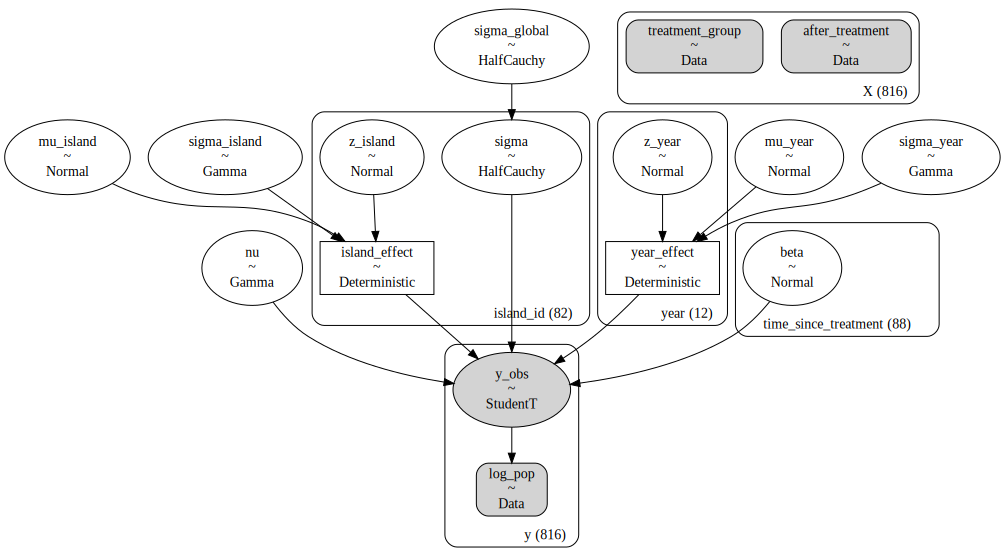

In [277]:
# 年をダミー化
year_dummies = dmatrix('C(year)-1', df, return_type='dataframe')
year_dummies.drop('C(year)[1960]', axis=1, inplace=True)
# 介入経過年数をダミー化
time_since_treatment_dummies = dmatrix('C(time_since_treatment) - 1', df, return_type='dataframe')
time_since_treatment_dummies.drop(columns=['C(time_since_treatment)[-46.0]', 'C(time_since_treatment)[1000.0]'], axis=1, inplace=True)
COORDS = {
    'y': df.index,
    'X': df.index,
    'island_id': mn_island_ids,
    'year': year_dummies.columns,
    'time_since_treatment': time_since_treatment_dummies.columns,
}

with pm.Model(coords=COORDS) as model_hetero:
    # data
    log_pop = pm.Data('log_pop', df['log_pop'], dims='y')
    treatment_group = pm.Data('treatment_group', df['treatment_group'], dims='X')
    after_treatment = pm.Data('after_treatment', df['after_treatment'], dims='X')

    # priors
    # random effect

    mu_island = pm.Normal('mu_island', mu=5, sigma=1)
    sigma_island = pm.Gamma('sigma_island', alpha=3, beta=1)
    z_island = pm.Normal('z_island', mu=0, sigma=1, dims='island_id')
    island_effect = pm.Deterministic('island_effect', mu_island + sigma_island * z_island, dims='island_id')

    mu_year = pm.Normal('mu_year', mu=-0.1, sigma=1)
    sigma_year = pm.Gamma('sigma_year', alpha=2, beta=1)
    z_year = pm.Normal('z_year', mu=0, sigma=1, dims='year')
    year_effect = pm.Deterministic('year_effect', mu_year + sigma_year * z_year, dims='year')

    sigma_global = pm.HalfCauchy('sigma_global', 1)
    sigma = pm.HalfCauchy('sigma', beta=sigma_global, dims='island_id')

    # fixed effect
    # alpha = pm.Normal('alpha', qmu=0, sigma=1)
    beta = pm.Normal('beta', mu=0, sigma=1, dims='time_since_treatment')
    nu = pm.Gamma('nu', alpha=2, beta=0.1)

    # expectation
    mu = pm.math.dot(time_since_treatment_dummies, beta) + island_effect[island_id] + pm.math.dot(year_dummies, year_effect)

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=nu, mu=mu, sigma=sigma[island_id], observed=log_pop, dims='y')

pm.model_to_graphviz(model_hetero)

In [278]:
with model_hetero:
    trace_hetero = pm.sample(
        draws=500,
        tune=500,
        chains=4,
        nuts_sampler='numpyro',
        random_seed=42,
        target_accept=.99
    )

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [279]:
az.summary(trace_hetero, var_names=['sigma_global', 'mu_island', 'sigma_island', 'mu_year', 'sigma_year', 'nu'], hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma_global,0.165,0.020,0.129,0.207,0.001,0.001,299.0,561.0,1.11
mu_island,6.418,0.142,6.099,6.674,0.044,0.032,11.0,93.0,1.36
sigma_island,1.981,0.156,1.609,2.356,0.063,0.047,6.0,15.0,1.76
mu_year,-0.490,0.172,-0.889,-0.165,0.052,0.038,11.0,28.0,1.30
sigma_year,0.627,0.125,0.387,0.861,0.013,0.009,81.0,170.0,1.50
nu,27.495,14.187,8.756,57.363,2.064,1.469,46.0,397.0,1.15


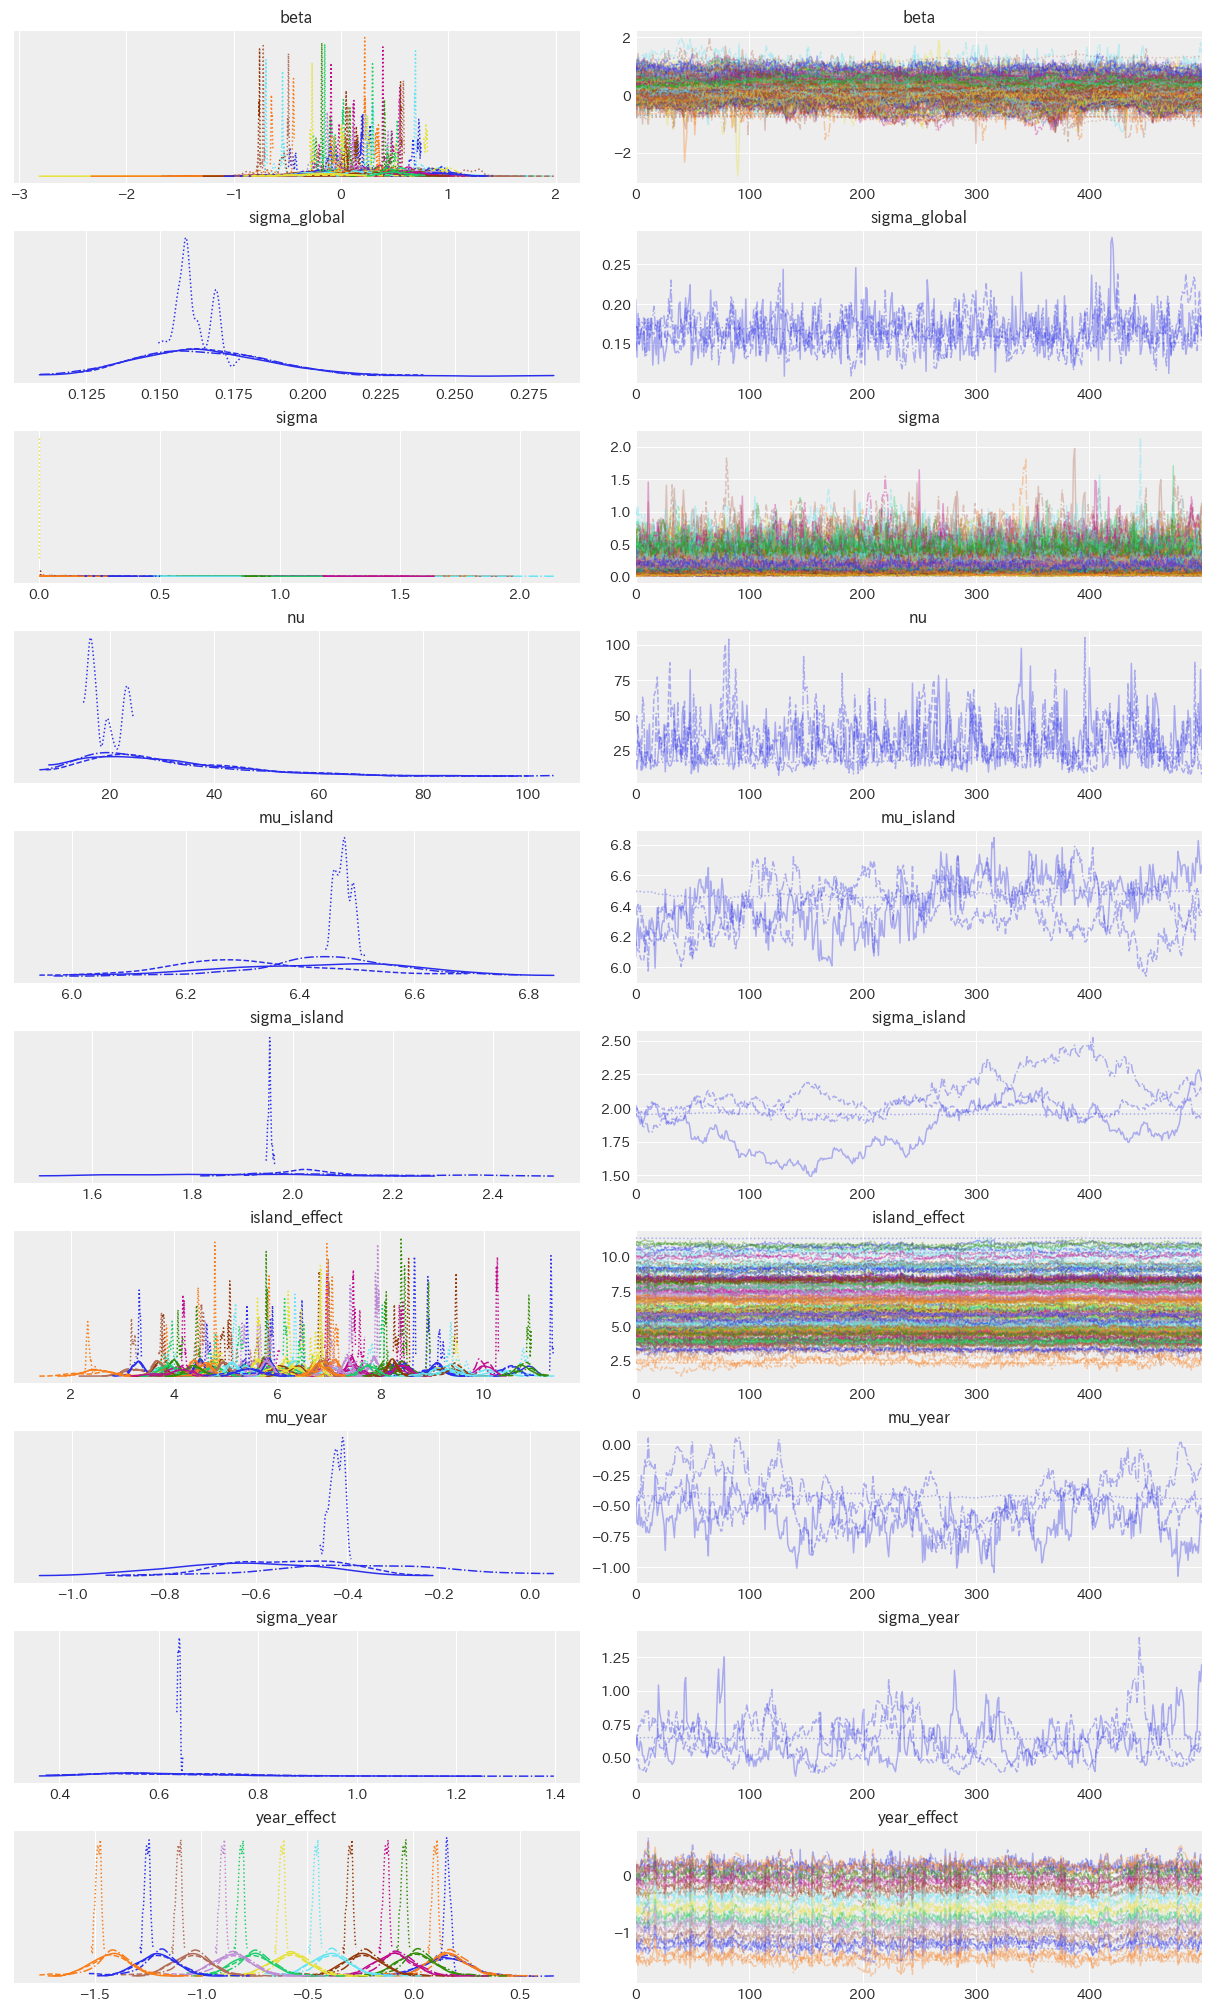

In [280]:
az.plot_trace(
    trace_hetero,
    var_names=[
        'beta', 'sigma_global', 'sigma', 'nu',
        'mu_island', 'sigma_island', 'island_effect',
        'mu_year', 'sigma_year', 'year_effect',
    ]
);

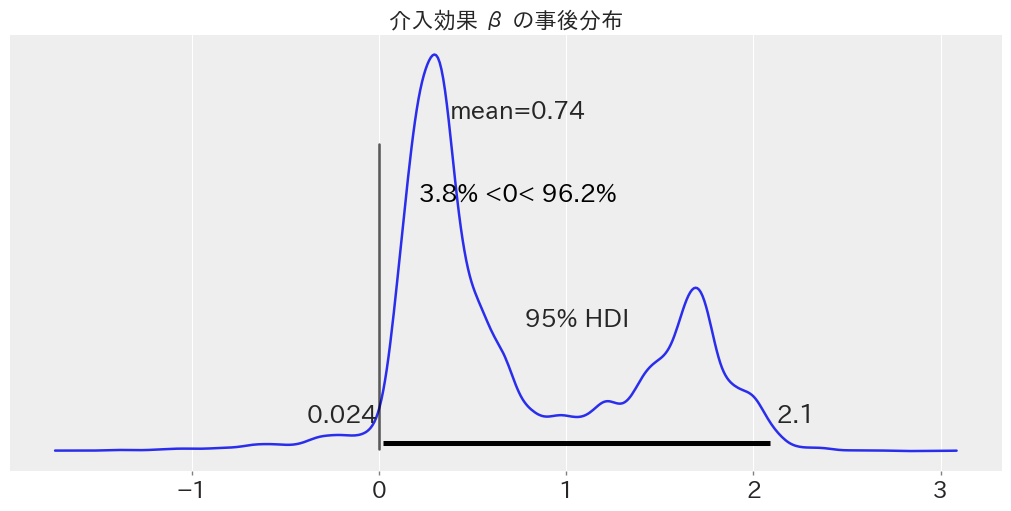

In [59]:
az.plot_posterior(trace_hetero, var_names=['mu_beta'], hdi_prob=0.95, ref_val=0, ref_val_color='k', figsize=(10 ,5));
plt.title('介入効果 β の事後分布');

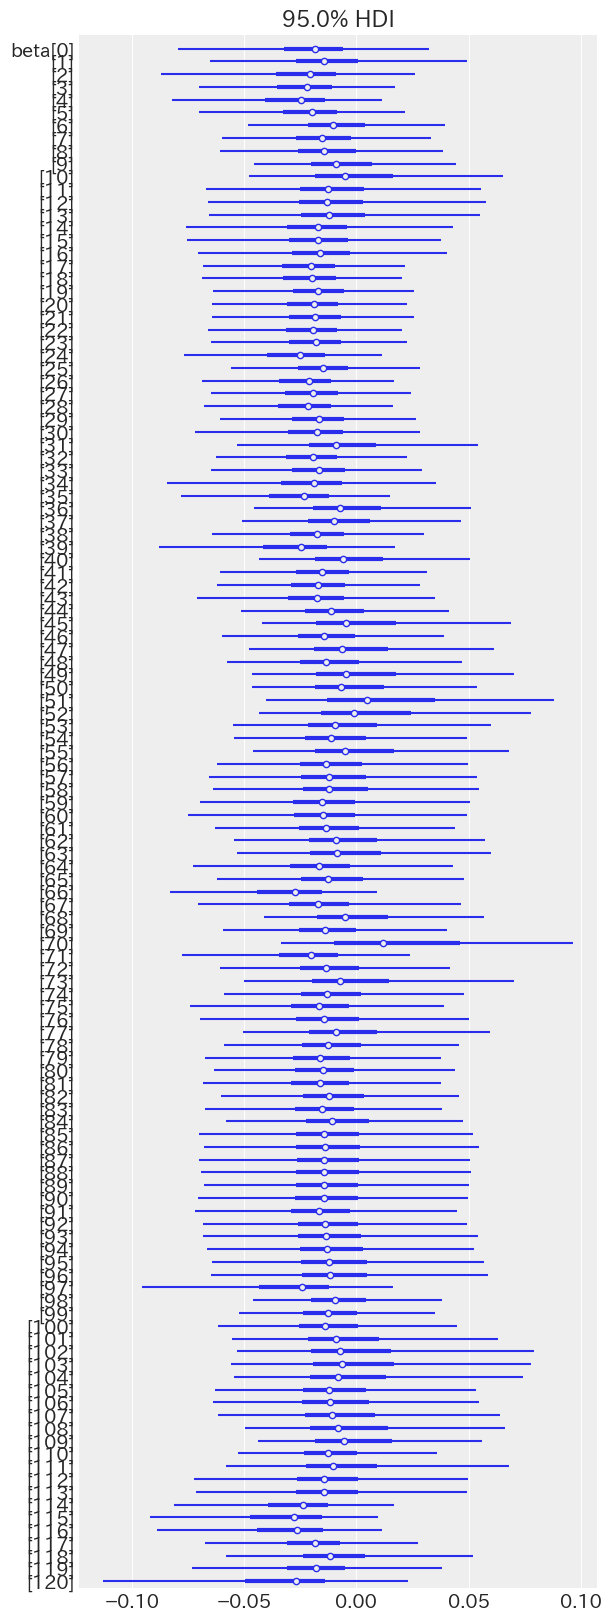

In [16]:
az.plot_forest(trace_dynamic_twfe, var_names=['beta'], combined=True, hdi_prob=0.95);

In [9]:
az.waic(trace_dynamic_twfe)

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 8000 posterior samples and 1723 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   494.26    42.64
p_waic      103.58        -

There has been a warning during the calculation. Please check the results.

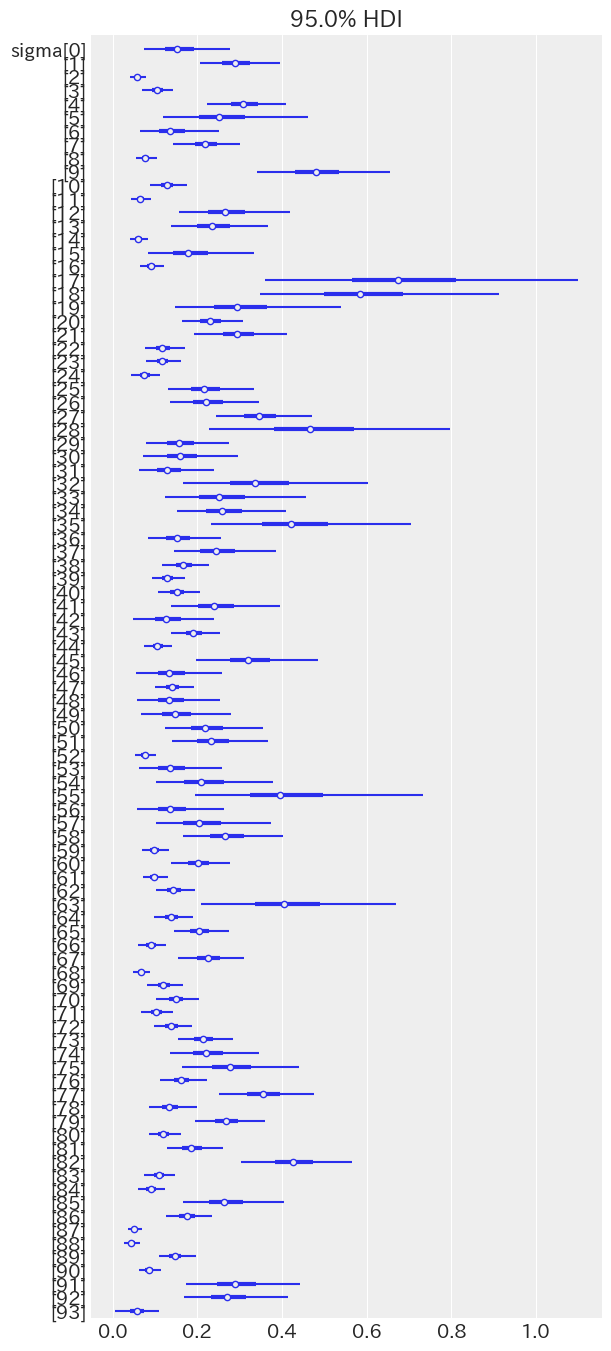

In [75]:
az.plot_forest(trace_dynamic_twfe, var_names=['sigma'], combined=True, hdi_prob=0.95);

## 階層ベイズモデル 均一分散

$$
\begin{aligned}
\log{Y_{it}} = \beta_i \cdot  W_{it} + \epsilon_{it} \\
\epsilon_{it} \sim N(0, \sigma^2)
\end{aligned}
$$

In [173]:
pre = df.query('treatment_group == 1 and after_treatment == 0')['log_pop'].mean()
post = df.query('treatment_group == 1 and after_treatment == 1')['log_pop'].mean()
post - pre

-0.09410949136313729

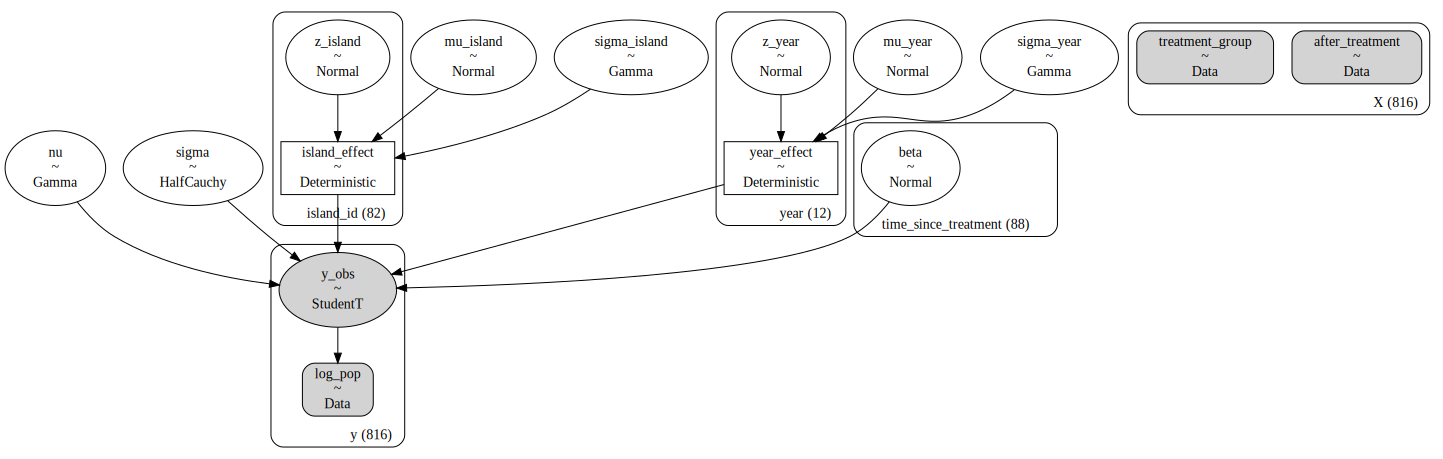

In [ ]:
# 年をダミー化
year_dummies = dmatrix('C(year)-1', df, return_type='dataframe')
year_dummies.drop('C(year)[1960]', axis=1, inplace=True)
# 介入経過年数をダミー化
time_since_treatment_dummies = dmatrix('C(time_since_treatment) - 1', df, return_type='dataframe')
time_since_treatment_dummies.drop(columns=['C(time_since_treatment)[-46.0]', 'C(time_since_treatment)[1000.0]'], axis=1, inplace=True)
COORDS = {
    'y': df.index,
    'X': df.index,
    'island_id': mn_island_ids,
    'year': year_dummies.columns,
    'time_since_treatment': time_since_treatment_dummies.columns,
}

with pm.Model(coords=COORDS) as model_homo:
    # data
    log_pop = pm.Data('log_pop', df['log_pop'], dims='y')
    treatment_group = pm.Data('treatment_group', df['treatment_group'], dims='X')
    after_treatment = pm.Data('after_treatment', df['after_treatment'], dims='X')

    # priors
    # random effect

    mu_island = pm.Normal('mu_island', mu=5, sigma=1)
    sigma_island = pm.Gamma('sigma_island', alpha=3, beta=1)
    z_island = pm.Normal('z_island', mu=0, sigma=1, dims='island_id')
    island_effect = pm.Deterministic('island_effect', mu_island + sigma_island * z_island, dims='island_id')

    mu_year = pm.Normal('mu_year', mu=-0.1, sigma=1)
    sigma_year = pm.Gamma('sigma_year', alpha=2, beta=1)
    z_year = pm.Normal('z_year', mu=0, sigma=1, dims='year')
    year_effect = pm.Deterministic('year_effect', mu_year + sigma_year * z_year, dims='year')

    sigma = pm.HalfCauchy('sigma', beta=1)

    # fixed effect
    # alpha = pm.Normal('alpha', qmu=0, sigma=1)
    beta = pm.Normal('beta', mu=0, sigma=1, dims='time_since_treatment')
    nu = pm.Gamma('nu', alpha=2, beta=0.1)

    # expectation
    mu = pm.math.dot(time_since_treatment_dummies, beta) + island_effect[island_id] + pm.math.dot(year_dummies, year_effect)

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=nu, mu=mu, sigma=sigma, observed=log_pop, dims='y')

pm.model_to_graphviz(model_homo)

In [269]:
with model_homo:
    trace_homo = pm.sample(
        draws=500,
        tune=500,
        chains=4,
        nuts_sampler='numpyro',
        random_seed=42
    )

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [224]:
az.to_netcdf(trace_homo, './mcmc_sample/dynamic/homo_kokucho_20240109.nc')

'./mcmc_sample/dynamic/homo_kokucho_20240109.nc'

In [270]:
az.summary(trace_homo, var_names=['beta'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[C(time_since_treatment)[-1.0]],0.342,0.168,0.007,0.648,0.007,0.005,686.0,765.0,1.01
beta[C(time_since_treatment)[-10.0]],-0.107,0.223,-0.513,0.326,0.009,0.006,661.0,1063.0,1.00
beta[C(time_since_treatment)[-11.0]],0.261,0.171,-0.088,0.565,0.007,0.005,724.0,758.0,1.00
beta[C(time_since_treatment)[-12.0]],-0.291,0.393,-1.021,0.490,0.014,0.010,833.0,829.0,1.00
beta[C(time_since_treatment)[-13.0]],-0.113,0.264,-0.612,0.349,0.011,0.007,619.0,849.0,1.01
...,...,...,...,...,...,...,...,...,...
beta[C(time_since_treatment)[55.0]],0.414,0.304,-0.136,0.962,0.011,0.008,741.0,1099.0,1.00
beta[C(time_since_treatment)[6.0]],0.150,0.239,-0.304,0.590,0.009,0.007,657.0,667.0,1.01
beta[C(time_since_treatment)[7.0]],0.086,0.249,-0.391,0.530,0.011,0.008,533.0,632.0,1.01
beta[C(time_since_treatment)[8.0]],-0.237,0.263,-0.710,0.271,0.011,0.008,588.0,769.0,1.00


In [272]:
az.summary(trace_homo, var_names=['sigma', 'mu_island', 'sigma_island', 'mu_year', 'sigma_year', 'nu'], hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.124,0.010,0.106,0.143,0.000,0.000,706.0,1097.0,1.00
mu_island,6.290,0.268,5.774,6.844,0.014,0.010,353.0,682.0,1.02
sigma_island,1.977,0.166,1.679,2.304,0.009,0.006,320.0,622.0,1.01
mu_year,-0.503,0.240,-0.949,-0.001,0.008,0.006,896.0,1089.0,1.00
sigma_year,0.623,0.166,0.361,0.956,0.005,0.004,802.0,923.0,1.01
nu,1.956,0.247,1.524,2.460,0.008,0.006,880.0,1191.0,1.01


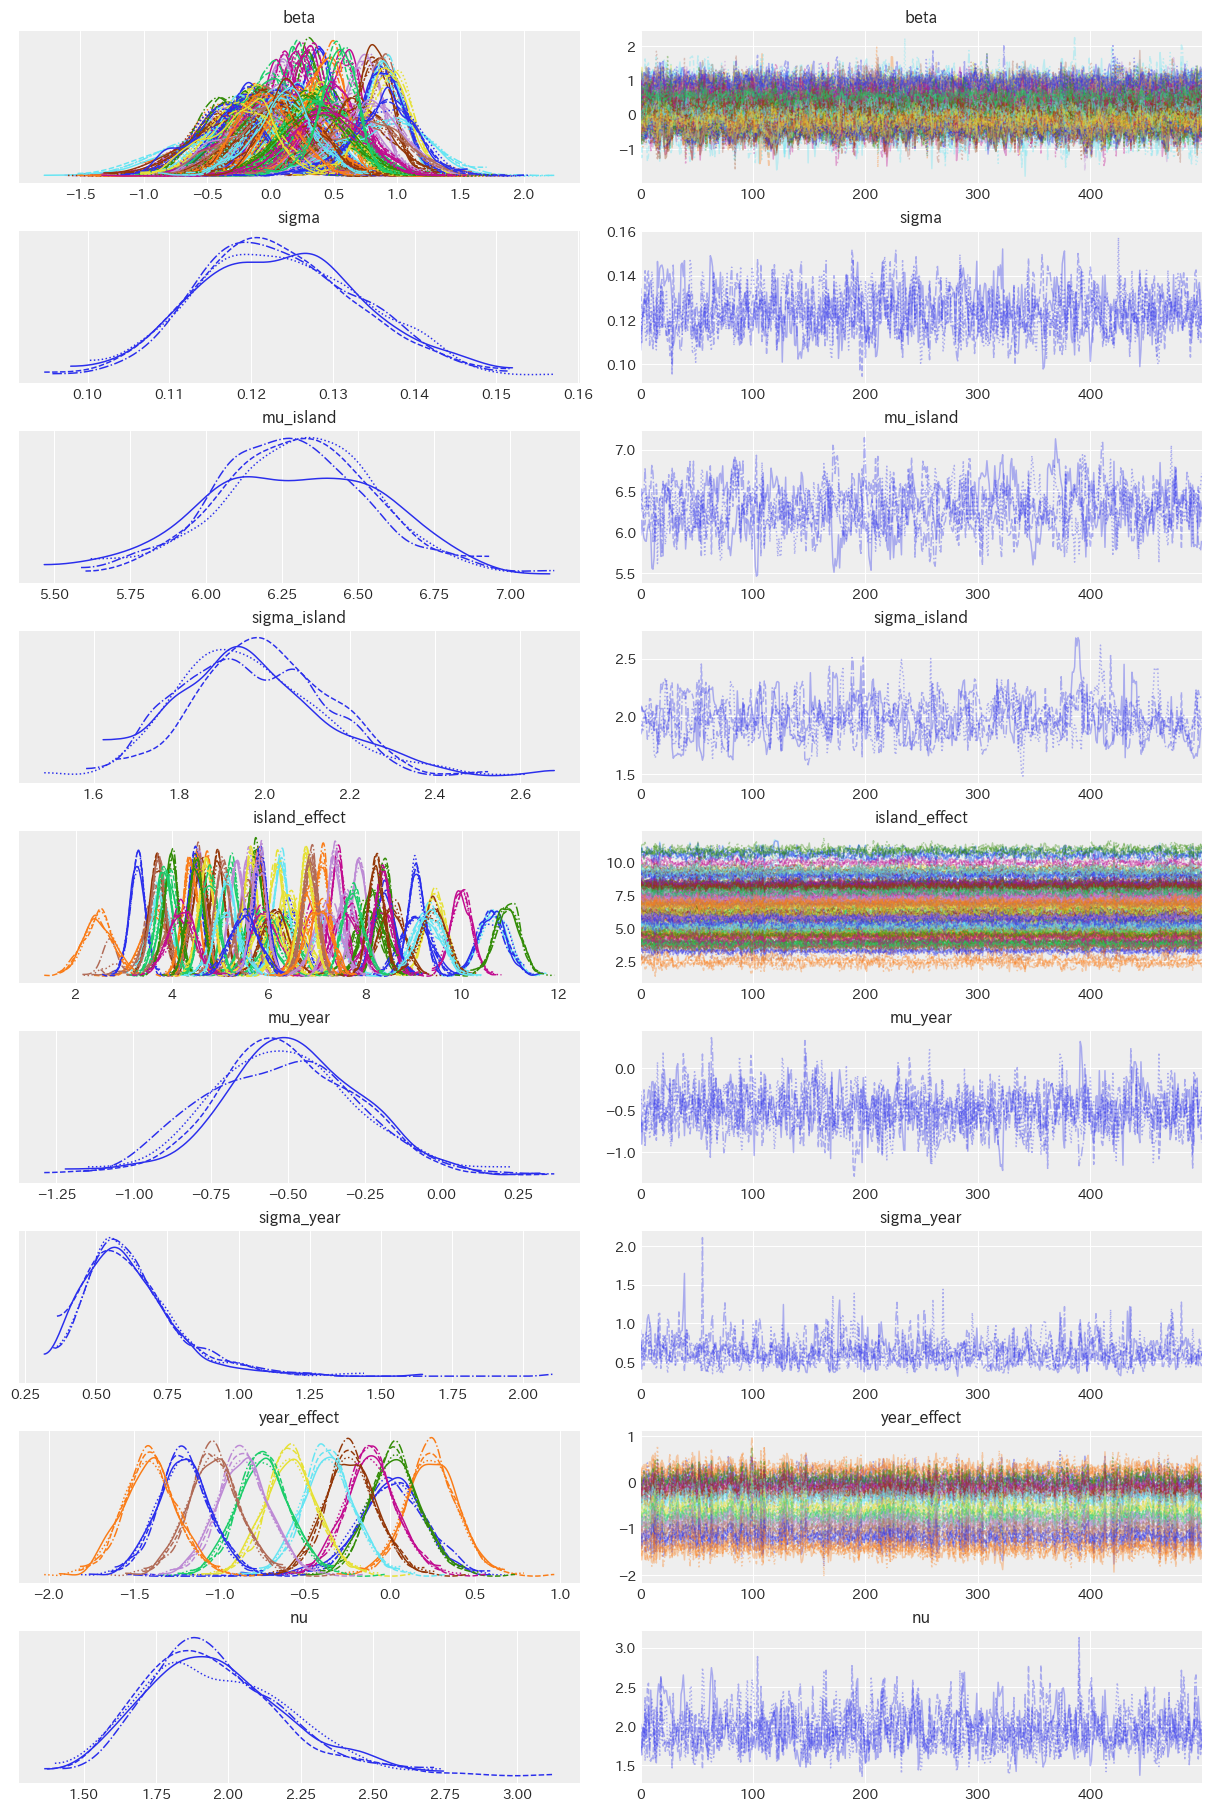

In [274]:
az.plot_trace(
    trace_homo,
    var_names=[
        'beta',
        'sigma',
        'mu_island', 'sigma_island', 'island_effect',
        'mu_year', 'sigma_year', 'year_effect',
        'nu'
    ]
);

In [134]:
with model_homo:
    pm.compute_log_likelihood(trace_homo)

az.waic(trace_homo)

Output()

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 816 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -85.08    34.39
p_waic      196.33        -

There has been a warning during the calculation. Please check the results.

## プロット

In [230]:
def get_beta_df(trace):
    # ランダム効果のサマリーを取得
    beta_df = az.summary(trace, var_names=['beta'], hdi_prob=0.95, kind='stats')

    # 経過年数
    # time_since_treatment_df = pd.DataFrame(unique_time_since_treatment, columns=['time_since_treatment_str'])
    # time_since_treatment_df['time_since_treatment'] = time_since_treatment_df['time_since_treatment_str'].apply(extract_number)

    # ランダム効果の値を経過年数と結合
    # ランダム効果の順番は経過年数の昇順ではなく，データに登場した順番になっている．
    # beta_df.reset_index(drop=True, inplace=True)
    # beta_df = pd.concat([beta_df, time_since_treatment_df], axis=1)
    # pattern = r'beta\[(\-?\d+.\d+)\]' # beta[-45.0]
    pattern = r"beta\[C\(time_since_treatment\)\[(-?\d+\.\d+)\]\]"
    extracted = beta_df.index.str.extract(pattern)
    extracted.index = beta_df.index
    beta_df['time_since_treatment'] = extracted[0].astype(float)
    beta_df = beta_df.query('time_since_treatment < 1000').sort_values('time_since_treatment')

    # 新しい列に数値を格納

    return beta_df

class BetaPlotter:
    def __init__(self, beta_df):
        self.beta_df = beta_df

    def plot_effects_over_time(self, title):
        fig, ax = plt.subplots(figsize=(10, 5))
        sns.lineplot(
            x='time_since_treatment',
            y='mean',
            data=self.beta_df,
            marker='o',
            color='black',
            label='Mean',
            ax=ax
        )
        ax.fill_between(
            x=self.beta_df['time_since_treatment'],
            y1=self.beta_df['hdi_97.5%'],
            y2=self.beta_df['hdi_2.5%'],
            color='gray',
            alpha=0.5,
            label='95% HDI'
        )
        ax.axvline(x=0, color='black', linestyle=':')
        ax.axhline(y=0, color='black', linestyle=':')
        ax.set_xlabel('経過年数')
        ax.set_ylabel('')
        ax.set_title(title)
        ax.legend()

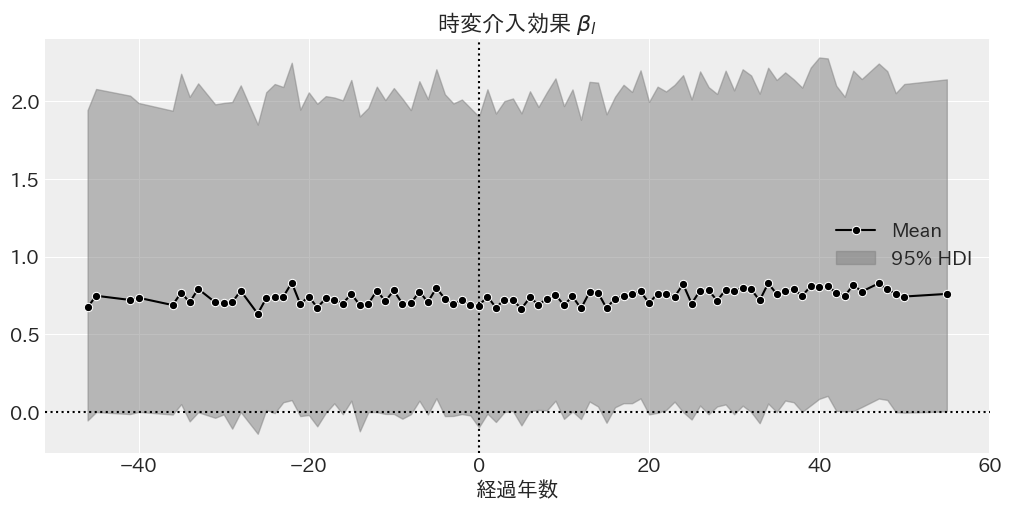

In [57]:
beta_df = get_beta_df(trace_hetero)
plotter = BetaPlotter(beta_df)
plotter.plot_effects_over_time('時変介入効果 $β_l$')

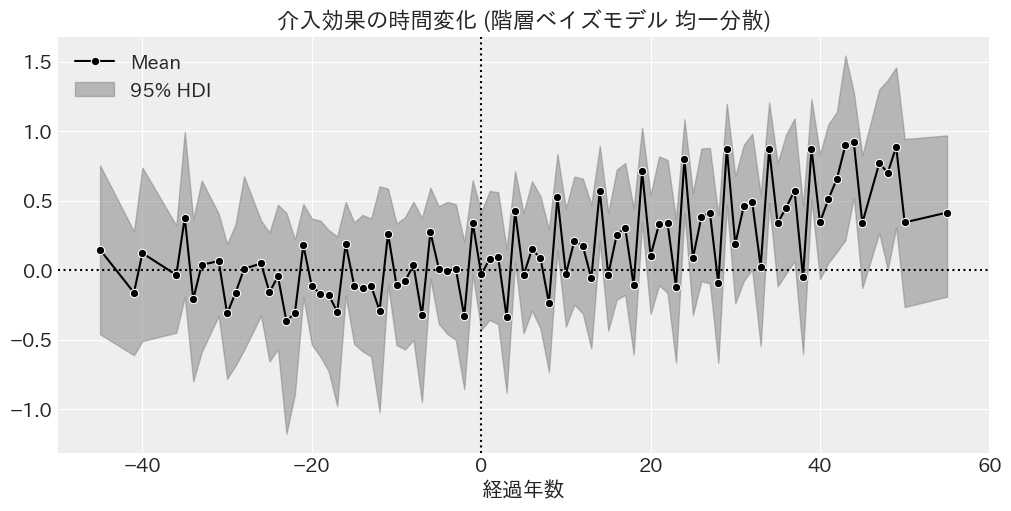

In [275]:
beta_df = get_beta_df(trace_homo)
plotter = BetaPlotter(beta_df)
plotter.plot_effects_over_time('介入効果の時間変化 (階層ベイズモデル 均一分散)')